# Effect of Noise on PINNs

#What is noise? Some definitions and introduction to stochastic processes
There is no such thing as a perfect data. All physical data in the world are obtained by some kind of devices; the devices always have uncertainty in measurements. Suppose we make $k=1, \ldots, N$ measuremens. If, at the $k$-th measurement, the device shows the value $X_k$, but the true value if $x_k$, then the difference $\epsilon_k = X_k - x_k$ is called the error of measurements. Usually this error comes from some unpredictable situations that cannot be modelled, such as small fluctuations in resistors of the device, little vortices in the air in front of anemometer \emph{etc.} We do not intend to model these variable at each measurements, as it would be equivalent to try to predict the result of a coin toss using massive simulation of coin moving through the air. Most of the time, such efforts are simply meaningless and unnecessary.

## Discrete probablility
Instead of trying to predict the unpredictable, we simply 'give up' on trying to predict the value of $\epsilon_k$ or $X_k$ on each measurement and make it a random variable. What is exactly a random variable? The exact definition is rather and convoluted - it took the genius of A.N.Kolmogorov to define it properly, and is definitely beyond this class. But you can think of it as a variable that visits a set of certain numbers, say $Y = \{ Y_1, Y_2, \ldots , Y_M \}$ with certain probability for $X$ to take each value $Y_i$.


## Probability distribution on an interval; probability density
Alternatively, you can say that the values of $X$ are in the interval $Y = [a,b]$, and the probability to find $X_k$ in the interval $[y, y + \Delta y]$ is proportional to $\rho(y) \Delta y$ for small $\Delta y$. In that case, $\rho(y)$ is called the probability density. We need to have
$$\rho(y)>0 \quad \mbox{ and } \int_a^b \rho(y) \mbox{d} y =1$$
so the probability of finding a function somewhere is 1.  

## Probability measure
More often than not, probability is not a continuous function and it can't be differentiated; it can even be discontinuous, has spikes etc. So we say that the probability to find $X_k$ in the interval $[y, y + \Delta y]$ is proportional to $\mu(y + \Delta y) - \mu(y)$ for some function $\mu$. Then, $\mu$ is called the probability measure. Then $\mu(y)$ needs to be a non-decreasing function with the probability to find an event someplace being exactly $1$:
$$
\mu(y_1) \leq \mu(y_2) \, \, \mbox{if} \, \,  y_1 \leq y_2, \quad \mu(b) - \mu(a) = 1
$$


#Applications of probabilitic ideas to data analysis in PINNs

Suppose now you have taken some measurements and you want to model a systems using PINNs. The problem we will consider now is parameter determination. We will assume that we will have the same problem as before, \emph{i.e.} a known PDE with known data points, but unknown parameters. Our goal would be to find the values of parameters when there is data points are known only up to noise.

However, before we do that, let us investigate how to deal with random numbers and distributions in Python.

#Stochastic differential equations

Sometimes very complex forces acting on the system are modeled by stochastic term on the right hand side. Equations of that type are called \emph{Stochastic Differential Equations} (SDEs) and are usually written in the form
$$
\mbox{d} \mathbf{Y} = \mathbf{f} (\mathbf{Y},t) \mbox{d} t + \boldsymbol{\sigma} \mbox{d} W_t \, , \quad \mathbf{Y}(t_0) = \mathbf{Y}_0.
$$
where $\mathbf{f} (\mathbf{Y},t)$ is the drift term and $\boldsymbol{\sigma} \mbox{d} W_t$ is the noise term, which is assumed to be the standard Brownian motion. There may be several different noise terms, or noise can be taken to be different from the standard Brownian motion \emph{etc.} The difference of this equation with the standard ODE is that the solution depends on the realizaiton of the noise, so it is not very useful to compute an individual solution. Instead, one computes the evolution of some kind of average quantities of that equation. As you can imagine, computing PINNs for an individual realization of noise is also not meaningful; but one can compute the PINNs-based solution based on averaged quantities, such as in

[1] Zhang, D., Guo, L., & Karniadakis, G. E. (2020). Learning in modal space: Solving time-dependent stochastic PDEs using physics-informed neural networks. SIAM Journal on Scientific Computing, 42(2), A639-A665.

[2] O'Leary, J., Paulson, J. A., & Mesbah, A. (2022). Stochastic physics-informed neural ordinary differential equations. Journal of Computational Physics, 468, 111466.

and many other recent works. We are not going to consider such equations here because of lack of time, and because proper preparation for this topic requires considerable background in stochastic ODEs/PDEs and probability theory.

<a id="0"></a> <br>
#Table of Contents
1. [Lotka-Voltera equations](#1)   
1. [The Helmholtz equation](#2)         
1. [The transport equation](#3)       
1. [Inviscid Burgers' equation](#4)
1. [Viscous Burgers' equation](#5)   
1. [The KDV equation](#6)


In [ ]:
!pip install deepxde &> /dev/null

In [ ]:
import numpy as np
import tensorflow as tf
import scipy
from scipy.integrate import solve_ivp, odeint
import deepxde as dde
import matplotlib.pyplot as plt


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Define the constants and the functions that will be used throught the notebook.

In [ ]:
pi = np.pi

## A quick review of random numbers and distributions in Python

### The normal distribution

Let's sample `sample_size` observation from the normal distribution $N(\mu, \sigma)$ using Python function `random.normal`, and compare the densities to their true values.

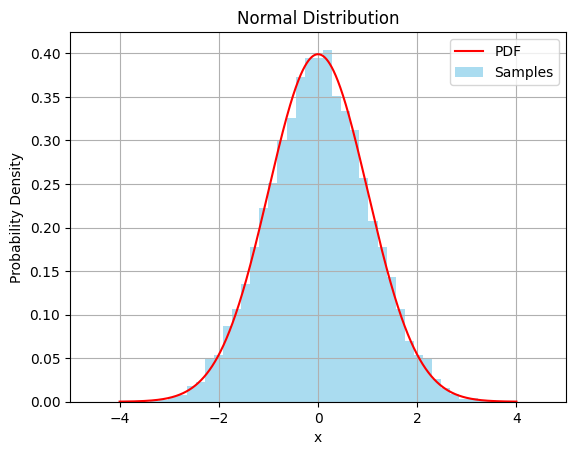

In [ ]:
sample_size = 10000
mean = 0 # the mean
std = 1 # the standard deviation

x = np.linspace(-4, 4, sample_size)
y = scipy.stats.norm.pdf(x, mean, std)
Samples = np.random.normal(mean, std, sample_size)
plt.hist(Samples, bins=40, alpha=0.7, color='skyblue', density=True)
plt.plot(x, y, color='red')
plt.title('Normal Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend(['PDF', 'Samples'])
plt.grid(True)
plt.xlim(-5,5)
plt.show()

### Laplace distribution

The [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) ${ \operatorname {Laplace} (\mu ,b)}$ distribution has probability density function  $$ f(x|\mu ,b)={\frac {1}{2b}}\exp \left(-{\frac {|x-\mu |}{b}}\right),$$
were
$ \mu \in \mathbb{R}$ is a location parameter, and $ b>0$, which  is a scale parameter. If $ \mu =0$ and
$ b=1$, the positive half-line is exactly an exponential distribution scaled by $1/2$.

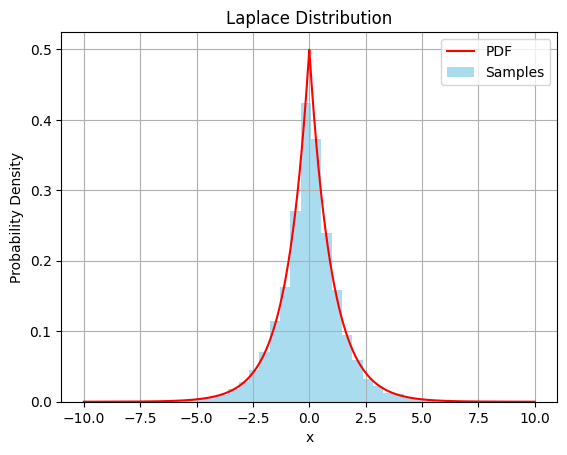

In [ ]:
mu = 0
b = 1
sample_size = 10000
samples = np.random.laplace(mu, b, sample_size)
x = np.linspace(-10, 10, sample_size)
y = scipy.stats.laplace.pdf(x, mu, b)
plt.hist(samples, bins=40, alpha=0.7, color='skyblue', density=True)
plt.plot(x, y, color="red")

plt.title('Laplace Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend(['PDF', 'Samples'])
plt.grid(True)
plt.show()

### Gamma distribution

The [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) is a two parameter continuous distribution. The two parameters are denoted $\alpha$ and $\beta$ and are called, respecively, **shape** and **rate**. A random variable X that is gamma-distributed with shape $\alpha$ and rate $\beta$ is denoted
$$ X\sim \Gamma (\alpha ,\beta ).$$
The probability density function of $\Gamma(\alpha, \beta)$ is  

$$ {\begin{aligned}f(x;\alpha ,\beta )&={\frac {x^{\alpha -1}e^{-\beta x}\beta ^{\alpha }}{\Gamma (\alpha )}}\quad {\text{ for }}x>0\quad \alpha ,\beta >0,\\[6pt]\end{aligned}}$$
where
$\Gamma (\alpha )$ is the gamma function defined by $$ \Gamma (z)=\int _{0}^{\infty }t^{z-1}e^{-t}{\text{ d}}t,\ \qquad \Re (z)>0\,.$$

Define the probability distribution function of the distribution

In [ ]:
def gamma_pdf(x, alpha, beta):
    return np.power(x, alpha-1) * np.exp(-x/beta) / (np.math.gamma(alpha) * beta**alpha)

<ipython-input-16-45d67dcaac22>:2: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.power(x, alpha-1) * np.exp(-x/beta) / (np.math.gamma(alpha) * beta**alpha)


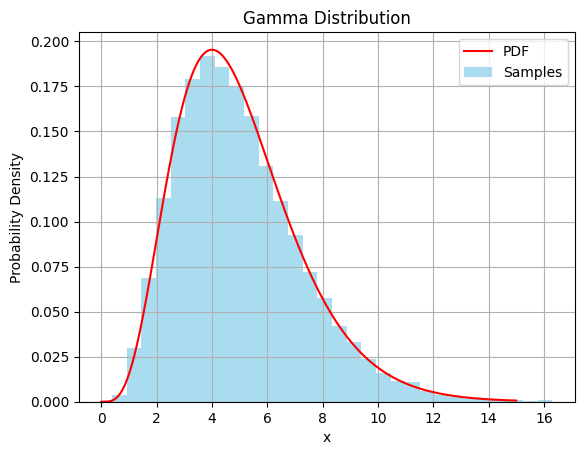

In [ ]:
alpha = 5
beta = 1
sample_size=10000

samples = np.random.gamma(alpha, beta, size=sample_size)
x = np.linspace(0, 15, sample_size)
pdf = gamma_pdf(x, alpha, beta)

plt.hist(samples, bins=30, density=True, alpha=0.7, color='skyblue')
plt.plot(x, pdf, color='red')

plt.title('Gamma Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend(['PDF', 'Samples'])
plt.grid(True)
plt.show()

### Student's t-distribution


[Student's t distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) has the probability density function  given by

$$ f(t)={\frac {\ \Gamma ({\frac {\ \nu +1\ }{2}})\ }{\ {\sqrt {\pi \ \nu \ }}\ \Gamma ({\frac {\nu }{2}})}}\left(\ 1+{\frac {~t^{2}\ }{\nu }}\ \right)^{-(\nu +1)/2}\ ,$$
where
$ \nu $ is the degree of freedom and $ \Gamma $ is the gamma function defined above. The PDF of the Student's t distribution is defined in `scipy.stats.t.pdf`.

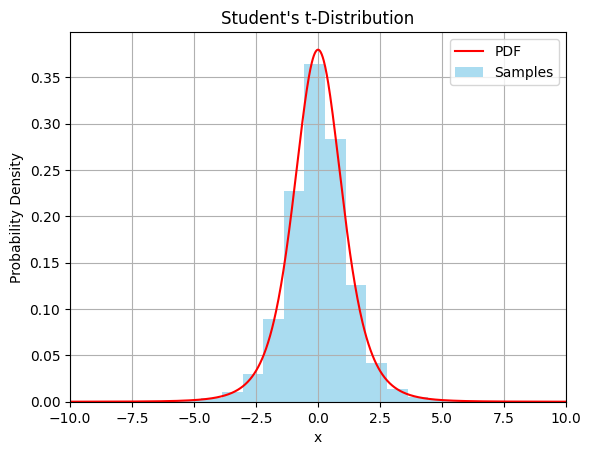

In [ ]:
df = 5  # Degrees of freedom
sample_size = 100000

samples = np.random.standard_t(df, size=sample_size)
x = np.linspace(-10, 10, 1000)
pdf = scipy.stats.t.pdf(x, df)

plt.hist(samples, bins=40, density=True, alpha=0.7, color='skyblue')
plt.plot(x, pdf, color="red")
plt.title("Student's t-Distribution")
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend(['PDF', 'Samples'])
plt.grid(True)
plt.xlim(-10,10)
plt.show()

#Effect of noise on determination of parameters

We now try to determine the parameters of equations when the data is corrupted by noise. We will investigate the accuracy of parameters depending on the noise level in the data.

## Lotka-Voltera equations

Consider the Lotka-Volterra equations, also known as the Lotka-Volterra predator-prey model:
$$
\begin{cases}
\frac{d x}{dt}= \alpha x - \beta xy \\
\frac{d y}{dt} = - \gamma y + \delta xy .
\end{cases}
$$

We want to find the parameters  $(\alpha, \beta, \gamma, \delta ) = (2/3, 4/3, 1, 1)$ given some known data points.

In [ ]:
alpha_star = 0.66
beta_star = 1.33
gamma_star = 1.
delta_star = 1.

The initial values $x(0) = 1, y(0) = 1$:

In [ ]:
x0 = 1
y0 = 1

We use data points generated using  the method `solve_ivp` in SciPy.

In [ ]:
def Lotka_Voltera_func(t, q):
    x, y = q
    dx_t = alpha_star*x - beta_star*x*y
    dy_t = delta_star*x*y - gamma_star*y
    return dx_t, dy_t


def Lotka_Voltera_traindata():
    t = np.linspace(0, 10, 100)
    sol = solve_ivp(Lotka_Voltera_func, (0, 10), (x0, y0), t_eval=t)
    return t.reshape(100, 1), sol.y.T

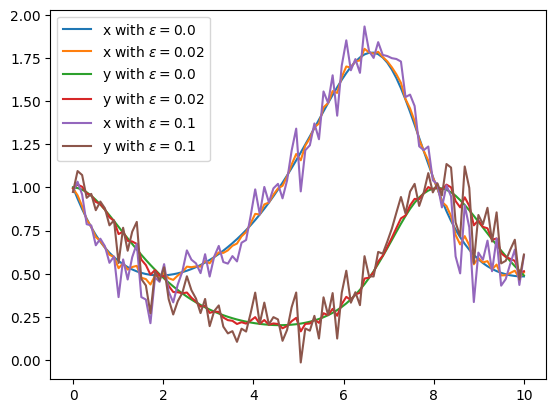

In [ ]:
epsilon = 0.015
noise = np.random.normal(0, 1, 100)
z, y = Lotka_Voltera_traindata()
plt.plot(z, y[:,0], label="x with $\epsilon=0.0$")
plt.plot(z, y[:,0]+ 0.02*noise, label="x with $\epsilon=0.02$")
plt.plot(z, y[:,1], label="y with $\epsilon=0.0$")
plt.plot(z, y[:,1]+ 0.02*noise, label="y with $\epsilon=0.02$")
plt.plot(z, y[:,0]+ 0.1*noise, label="x with $\epsilon=0.1$")
plt.plot(z, y[:,1]+ 0.1*noise, label="y with $\epsilon=0.1$")
plt.legend()
plt.show()

In [ ]:
def noisy_Lotka_Voltera(epsilon=0):
    noise = epsilon*np.random.normal(0, 1, [100, 2])
    t = np.linspace(0, 10, 100)
    sol = solve_ivp(Lotka_Voltera_func, (0, 10), (x0, y0), t_eval=t)
    return t.reshape(100, 1), sol.y.T + noise

We define the variables that we want to find and the model:

In [ ]:
geom = dde.geometry.TimeDomain(0, 2.0)
net = dde.nn.FNN([1] + [64] * 6 + [2], "tanh", "Glorot normal")

def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )

def output_transform(t, q):
    x = q[:, 0:1]
    y = q[:, 1:2]
    return tf.concat([x * tf.tanh(t) + x0, y * tf.tanh(t) + y0], axis=1)

net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

In [ ]:
def train_with_noise(epsilon):
    alpha = tf.Variable(1.0)
    beta = tf.Variable(1.0)
    gamma = tf.Variable(1.0)
    delta = tf.Variable(1.0)

    def Lotka_Voltera_eq(t, q):
        x = q[:, 0:1]
        y = q[:, 1:2]
        dx_t = dde.grad.jacobian(q, t, i=0)
        dy_t = dde.grad.jacobian(q, t, i=1)
        return [
            dx_t - alpha*x + beta*x*y,
            dy_t - delta*x*y + gamma*y
        ]

    # Get the training data
    observe_t, ob_y = noisy_Lotka_Voltera(epsilon)
    observe_y0 = dde.icbc.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
    observe_y1 = dde.icbc.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
    bcs = [observe_y0, observe_y1]

    data = dde.data.PDE(geom,
                        Lotka_Voltera_eq,
                        bcs,
                        num_domain=400,
                        num_boundary=2,
                        anchors=observe_t,)

    model = dde.Model(data, net)

    parameters = dde.callbacks.VariableValue([alpha, beta, gamma, delta], period=1000)
    model.compile("adam", lr=0.001)
    losshistory, train_state = model.train(iterations=2000, callbacks=[parameters])
    return parameters.value
    #Investigate the number of iterations - sometimes 2000 is not enough

In [ ]:
#epsilon = [0., 0.01, 0.02, 0.04, 0.06, 0.08, 0.1]
epsilon = np.linspace(0,0.5,6)
param = []
for eps in epsilon:
    param.append(train_with_noise(eps))

Compiling model...
Building feed-forward neural network...
'build' took 0.161650 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.531961 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.12e+00, 1.92e+00, 4.71e-01, 6.37e-01]    [1.12e+00, 1.92e+00, 4.71e-01, 6.37e-01]    []  
0 [1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00]
1000      [9.93e-05, 2.98e-05, 4.39e-06, 3.85e-06]    [9.93e-05, 2.98e-05, 4.39e-06, 3.85e-06]    []  
1000 [6.58e-01, 1.32e+00, 1.00e+00, 1.00e+00]
2000      [3.65e-05, 1.07e-05, 1.03e-05, 2.42e-06]    [3.65e-05, 1.07e-05, 1.03e-05, 2.42e-06]    []  
2000 [6.56e-01, 1.32e+00, 1.00e+00, 1.00e+00]

Best model at step 2000:
  train loss: 5.99e-05
  test loss: 5.99e-05
  test metric: []

'train' took 12.904922 s

Compiling model...
'compile' took 0.862144 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.81e-01, 2.33e-01, 2.32e-01, 1.19e-01]    [1.81e-01, 2.33e-01, 2.32e-01, 1.19e-01]    []  
0 [1.0

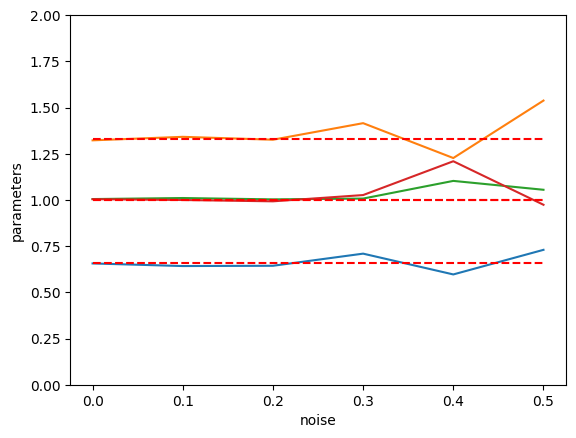

In [ ]:
plt.plot(epsilon, np.array(param)[:,0])
plt.plot(epsilon, np.array(param)[:,1])
plt.plot(epsilon, np.array(param)[:,2])
plt.plot(epsilon, np.array(param)[:,3])
plt.xlabel("noise")
plt.ylabel("parameters")
plt.ylim(0,2)
plt.hlines(y=[alpha_star, beta_star, gamma_star, delta_star],
           xmin=0, xmax=0.5, linestyles="--", color="r")
plt.show()

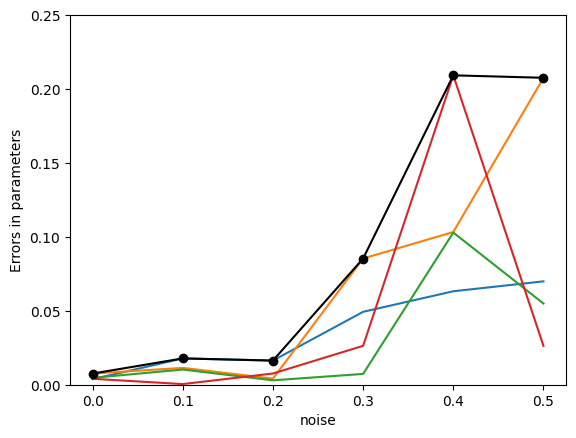

In [ ]:
true_params = np.array([alpha_star, beta_star, gamma_star, delta_star])
error_eps = np.abs(np.array(param)-np.outer(np.ones(len(epsilon)),true_params))
plt.plot(epsilon, error_eps[:,0])
plt.plot(epsilon, error_eps[:,1])
plt.plot(epsilon, error_eps[:,2])
plt.plot(epsilon, error_eps[:,3])
plt.plot(epsilon,np.max(error_eps,axis=1),'ko-')
plt.xlabel("noise")
plt.ylabel("Errors in parameters")
plt.ylim(0,0.25)
plt.show()

## Helmholtz equation

Consider the Helmholtz equation $$ u_{xx}+u_{yy} + \kappa^2 u = -\kappa^2\sin(\kappa x)\sin(\kappa y), \qquad  \Omega = [0,1]^2$$
with the Dirichlet boundary conditions $$u(x,y)=0, \qquad (x,y)\in \partial \Omega.$$

We want to identify the parameter $\kappa$ given some known data points. The value is

In [ ]:
kappa_star = pi

We us the exact solution  $u(x,y)= \sin(\kappa x)\sin(\kappa y)$ to generate training data points.

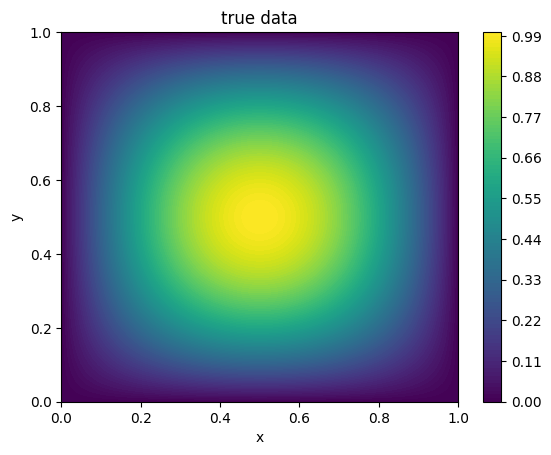

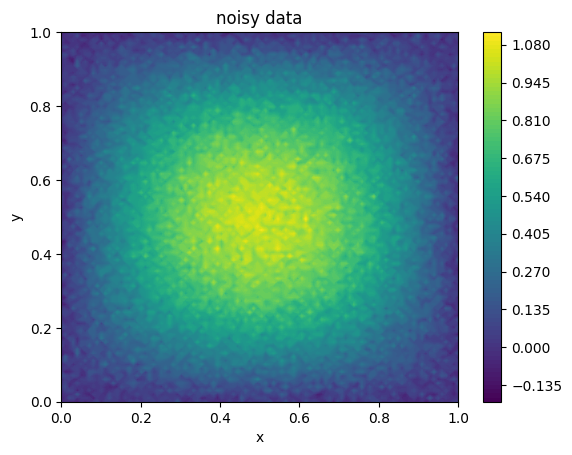

In [ ]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
def helm_sol(z):
    return np.sin(kappa_star * z[:, 0:1]) * np.sin(kappa_star * z[:, 1:2])
z = np.stack((X.flatten(), Y.flatten()), 1)
Z = helm_sol(z).reshape(100, 100)

plt.contourf(X, Y, Z, levels=100)
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.title("true data")
plt.show()
noise = np.random.normal(0, 1, [100,100])
plt.contourf(X, Y, Z + 0.05*noise, levels=100)
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.title("noisy data")
plt.show()

In [ ]:
def noisy_Helm_data(eps=0.0):
    z0 = np.random.uniform(0., 1., size=[100,1])
    z1 = np.random.uniform(0., 1., size=[100,1])
    z = np.hstack([z0, z1])
    noise = np.random.normal(0, 1, [100, 1])
    y = np.sin(kappa_star * z[:, 0:1]) * np.sin(kappa_star * z[:, 1:2])
    return z, y + eps*noise

Define the model

In [ ]:
num_train = 20

def boundary(_, on_boundary):
    return on_boundary

geom = dde.geometry.Rectangle([0, 0], [1, 1])
bc1 = dde.icbc.DirichletBC(geom, lambda z: 0, boundary)

def transform(z, u):
    res = z[:, 0:1] * (1 - z[:, 0:1]) * z[:, 1:2] * (1 - z[:, 1:2])
    return res * u

net = dde.nn.FNN(
    [2] + [64] * 4 + [1], "sin", "Glorot uniform"
)
net.apply_output_transform(transform)

In [ ]:
def train_with_noise(eps):
    kappa = tf.Variable(3.)

    def Helm_pde(z, u):
        # z = (x, y)
        du_xx = dde.grad.hessian(u, z, i=0, j=0)
        du_yy = dde.grad.hessian(u, z, i=1, j=1)

        f = kappa**2 * tf.sin(kappa * z[:, 0:1]) * tf.sin(kappa * z[:, 1:2])
        return du_xx + du_yy + u * kappa**2 + f

    observe_z, ob_u = noisy_Helm_data(eps)
    observe_u = dde.icbc.PointSetBC(observe_z, ob_u)

    data = dde.data.PDE(
        geom,
        Helm_pde,
        [observe_u],
        num_domain=num_train**2,
        num_boundary=4 * num_train,
        anchors=observe_z,
    )

    model = dde.Model(data, net)

    parameters = dde.callbacks.VariableValue([kappa], period=1000)
    model.compile("adam", lr=1e-3)
    losshistory, train_state = model.train(iterations=10000, callbacks=[parameters])
    return parameters.value

In [ ]:
epsilon = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
param = []
for eps in epsilon:
    param.append(train_with_noise(eps))

Compiling model...
Building feed-forward neural network...
'build' took 0.079457 s

'compile' took 1.613880 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.88e+01, 2.39e-01]    [1.88e+01, 2.39e-01]    []  
0 [3.00e+00]
1000      [2.05e-02, 1.15e-02]    [2.05e-02, 1.15e-02]    []  
1000 [2.90e+00]
2000      [1.07e-03, 8.50e-03]    [1.07e-03, 8.50e-03]    []  
2000 [2.93e+00]
3000      [2.73e-04, 4.34e-03]    [2.73e-04, 4.34e-03]    []  
3000 [2.99e+00]
4000      [5.80e-05, 1.47e-03]    [5.80e-05, 1.47e-03]    []  
4000 [3.06e+00]
5000      [4.17e-05, 2.68e-04]    [4.17e-05, 2.68e-04]    []  
5000 [3.11e+00]
6000      [4.69e-04, 2.73e-05]    [4.69e-04, 2.73e-05]    []  
6000 [3.13e+00]
7000      [5.91e-03, 7.46e-06]    [5.91e-03, 7.46e-06]    []  
7000 [3.14e+00]
8000      [5.90e-04, 2.18e-06]    [5.90e-04, 2.18e-06]    []  
8000 [3.14e+00]
9000      [1.42e-05, 2.13e-06]    [1.42e-05, 2.13e-06]    []  
9000 [3.14e+00]
10000     [1.

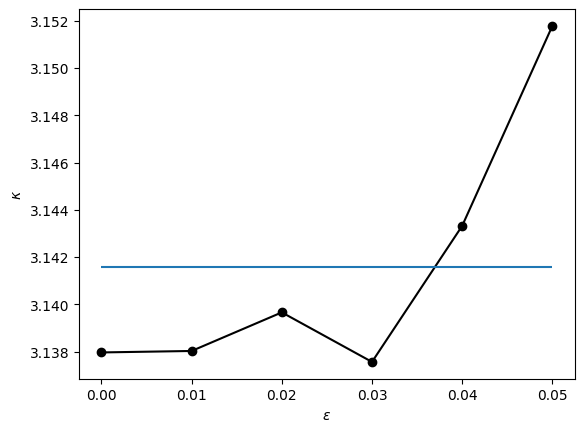

In [ ]:
plt.plot(epsilon, param, "ko-")
plt.xlabel("$\epsilon$")
plt.ylabel("$\kappa$")
plt.hlines(y=kappa_star, xmin=0, xmax=0.05)
plt.show()

## The transport equation

Consider the $1$-dimensional transport equation
$$ u_t + c u_x = 0, \qquad  (x, t)\in [- \infty,\infty]\times [0, 1] $$
with initial condition
$$u(x, 0) = g(x).$$

We take $x \in [-L,L]$ where $L$ is sufficiently large  to not  feel the effect of the boundaries.

In [ ]:
L = 2.

We want to identify the value of $c$ given some data points. The true value in this example is $c^*=3$.

In [ ]:
c_star = 3.

We use the exact solution
 $u(x, t) = g(x- tc)$ to generate the desired data points.

In [ ]:
x = np.linspace(-L,L,100)
t = np.random.uniform(0,1,100)
z = np.stack([x, t], 1)

def g_func(x):
    return np.sin(pi*x)

def noisy_transport_data(eps=0.0):
    y = g_func(z[:,0:1] - z[:,1:2]*c_star)
    return z, y + eps*np.random.normal(0, 1, [len(x), 1])

geom = dde.geometry.Interval(-L, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary(_, on_boundary):
    return on_boundary

ic = dde.icbc.IC(
    geomtime,
    lambda z: g_func(z[:,0:1]),
    boundary,
)

net = dde.nn.FNN(
    [2] + [64] * 4 + [1], "sin", "Glorot uniform"
)

In [ ]:
def train_with_noise(eps=0.0):
    C = tf.Variable(1.0)

    def transport_pde(z, u):
        du_x = dde.grad.jacobian(u, z, i=0, j=0)
        du_t = dde.grad.jacobian(u, z, i=0, j=1)

        return du_t + C * du_x

    observe_z, ob_u = noisy_transport_data(eps)
    observe_u = dde.icbc.PointSetBC(observe_z, ob_u)

    data = dde.data.TimePDE(
        geomtime,
        transport_pde,
        [ic, observe_u],
        num_domain=100,
        num_boundary=20,
        num_initial=16,
        anchors=observe_z,
    )

    parameters = dde.callbacks.VariableValue([C], period=1000)

    model = dde.Model(data, net)
    model.compile("adam", lr=1e-2)
    losshistory, train_state = model.train(iterations=10000, callbacks=[parameters])
    return parameters.value

In [ ]:
param = []
epsilon = [k*0.02 for k in range(6)]
for eps in epsilon:
    param.append(train_with_noise(eps))

Compiling model...
Building feed-forward neural network...
'build' took 0.071110 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.810257 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.31e-01, 8.94e-01, 6.68e-01]    [1.31e-01, 8.94e-01, 6.68e-01]    []  
0 [1.00e+00]
1000      [1.58e-03, 1.32e-03, 9.16e-04]    [1.58e-03, 1.32e-03, 9.16e-04]    []  
1000 [3.00e+00]
2000      [9.85e-04, 7.92e-04, 5.18e-04]    [9.85e-04, 7.92e-04, 5.18e-04]    []  
2000 [3.00e+00]
3000      [3.50e-04, 3.53e-04, 2.22e-04]    [3.50e-04, 3.53e-04, 2.22e-04]    []  
3000 [3.00e+00]
4000      [3.30e-05, 5.86e-05, 1.26e-04]    [3.30e-05, 5.86e-05, 1.26e-04]    []  
4000 [3.00e+00]
5000      [2.08e-04, 2.77e-03, 1.46e-03]    [2.08e-04, 2.77e-03, 1.46e-03]    []  
5000 [3.00e+00]
6000      [4.63e-06, 1.96e-05, 4.06e-05]    [4.63e-06, 1.96e-05, 4.06e-05]    []  
6000 [3.00e+00]
7000      [2.35e-06, 4.26e-05, 1.46e-04]    [2.35e-06, 4.26e-05, 1.46e-04]    []  
7000 [3.00e+00]
8000      [4.43e-07, 3.75e-06, 6.76e-06]    [4.43e-07, 3.75e-06, 6.76e-06] 

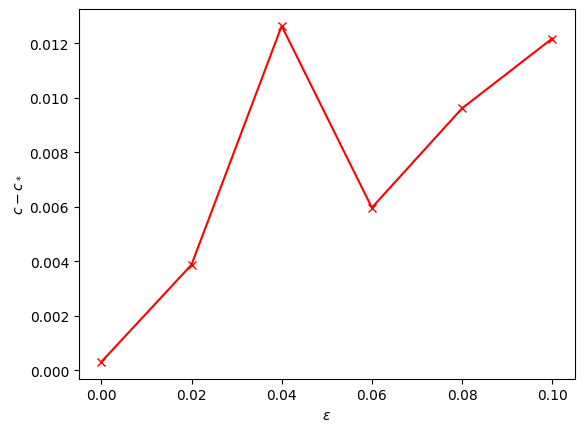

In [ ]:
plt.plot(epsilon, np.abs(np.array(param)-c_star), "rx-")
plt.xlabel("$\epsilon$")
plt.ylabel(r"$c-c_*$")
plt.show()

## Inviscid Burgers' equation

Consider the inviscid Burgers'  equation $$
u_t + uu_x = 0 $$
with the initial condition $$u\left(x,0\right) = ax+b .$$

We want to determine the values of $a$ and $b$ given some known data points.

In [ ]:
a_star = 2.
b_star = 3.

We generate the required data points using the exact solution  $$u(x,t)=\frac{ax+b}{at +1}.$$

In [ ]:
L = 2.
x = np.random.uniform(0, L, [100, 1])
t = np.random.uniform(0, 1, [100, 1])
z = np.hstack((x, t))
noise = np.random.normal(0, 1, [100, 1])
def noisy_inviscid(eps=0.0):
    y = (a_star*z[:,0:1] + b_star) / (a_star*z[:,1:2] + 1)
    return z, y + eps*noise

The model:

In [ ]:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def inviscid_burgers(z, u):
    # z = (x, t)
    u_x = dde.grad.jacobian(u, z, j=0)
    u_t = dde.grad.jacobian(u, z, j=1)
    return u_t + u * u_x

def boundary(_, on_initial):
    return on_initial

net = dde.nn.FNN([2] + [64] * 4 + [1], "tanh", "Glorot normal")

In [ ]:
def train_with_noise(eps=0.0):
    a = tf.Variable(1.)
    b = tf.Variable(1.)

    def inviscid_burgers0(x):
        return a*x + b

    ic = dde.icbc.IC(geomtime, lambda x: inviscid_burgers0(x[:,0:1]), boundary)

    # Get the train data
    observe_z, ob_u = noisy_inviscid(eps)
    observe_u = dde.icbc.PointSetBC(observe_z, ob_u)

    data = dde.data.TimePDE(
        geomtime, inviscid_burgers, ic_bcs=[ic, observe_u],
        num_domain=100, num_boundary=40, num_initial=16,
        anchors=observe_z,
    )

    model = dde.Model(data, net)
    parameters = dde.callbacks.VariableValue([a, b], period=1000)
    model.compile("adam", lr=1e-3)
    losshistory, train_state = model.train(iterations=12000, callbacks=[parameters])
    return parameters.value

In [ ]:
epsilon = [0.0, 0.01, 0.02, 0.04, 0.08, 0.1, 0.2]
param = []
for eps in epsilon:
    param.append(train_with_noise(eps))

Compiling model...
Building feed-forward neural network...
'build' took 0.093636 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.506312 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.45e-03, 4.04e+00, 9.24e+00]    [1.45e-03, 4.04e+00, 9.24e+00]    []  
0 [1.00e+00, 1.00e+00]
1000      [1.27e-02, 9.98e-02, 2.53e-01]    [1.27e-02, 9.98e-02, 2.53e-01]    []  
1000 [1.69e+00, 1.79e+00]
2000      [3.58e-03, 1.55e-02, 3.81e-02]    [3.58e-03, 1.55e-02, 3.81e-02]    []  
2000 [2.16e+00, 2.31e+00]
3000      [9.85e-04, 2.27e-03, 6.63e-03]    [9.85e-04, 2.27e-03, 6.63e-03]    []  
3000 [2.36e+00, 2.59e+00]
4000      [2.75e-04, 7.60e-04, 2.65e-03]    [2.75e-04, 7.60e-04, 2.65e-03]    []  
4000 [2.35e+00, 2.72e+00]
5000      [4.00e-04, 4.26e-04, 1.40e-03]    [4.00e-04, 4.26e-04, 1.40e-03]    []  
5000 [2.27e+00, 2.80e+00]
6000      [6.15e-05, 1.12e-04, 5.53e-04]    [6.15e-05, 1.12e-04, 5.53e-04]    []  
6000 [2.17e+00, 2.87e+00]
7000      [2.48e-05, 2.46e-05, 1.43e-04]    [2.48e-05, 2.46e-05, 1.43e-04]    []  
7000 [2.08e+00, 2.94e

In [ ]:
np.array(param)[:,0]

array([1.9968475, 2.003451 , 2.0134287, 2.0309072, 2.0545402, 2.0722504,
       2.1635098], dtype=float32)

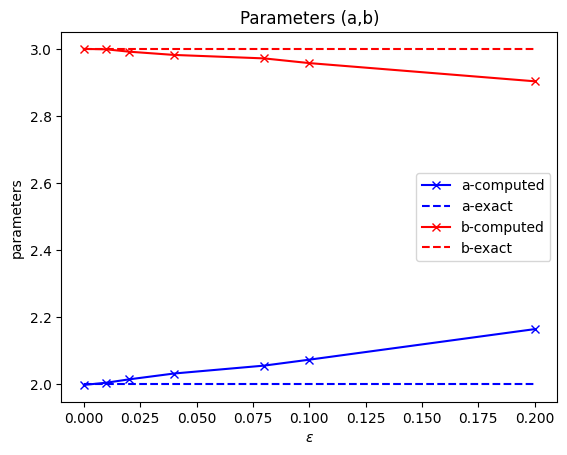

In [ ]:
plt.plot(epsilon, np.array(param)[:,0],'bx-',label='a-computed')
plt.plot(epsilon, a_star*np.ones(len(epsilon)),'b--',label='a-exact')
plt.plot(epsilon, np.array(param)[:,1],'rx-',label='b-computed')
plt.plot(epsilon, b_star*np.ones(len(epsilon)),'r--',label='b-exact')
plt.title('Parameters (a,b)')
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'parameters')
plt.legend()
plt.show()

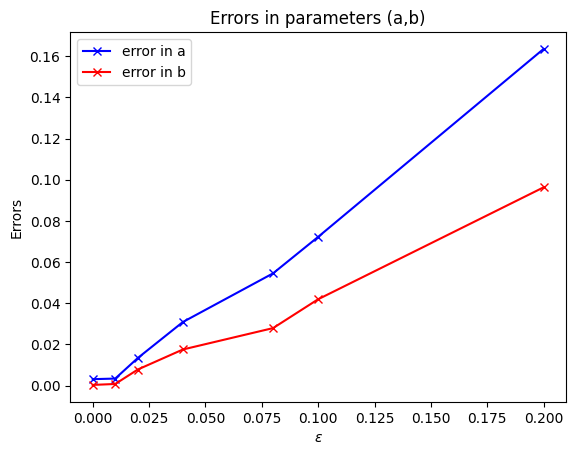

In [ ]:
plt.plot(epsilon, np.abs(np.array(param)[:,0]-a_star),'bx-',label='error in a')
plt.plot(epsilon, np.abs(np.array(param)[:,1]-b_star),'rx-',label='error in b')
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'Errors')
plt.title('Errors in parameters (a,b)')
plt.legend()
plt.show()

## Viscous Burgers' equation

Consider the equation $$u_t + uu_x = \nu u_{xx},$$
$$ u(x,0) = F(x),\qquad x\in [-L, L]$$
$$ u(-L, t)=u(L, t)=0,\qquad t\in [0,1].$$

We want to find the parameter $\nu$ given some known data points.

In [ ]:
nu_star = 0.1
L = 1 # half the length of the interval

The initial condition

In [ ]:
def u0_func(x):
   return -np.sin(pi*x)

We use points generated using a numerical solution

In [ ]:
nx = 1000
dx = 2*L / nx

# Define the time domain
tmax = 1.0
nt = 400
dt = tmax / nt

# Define the initial condition function
def initial_condition(x):
    return -np.sin(np.pi * x)

# Create arrays for the spatial and temporal grids
x = np.linspace(-L, L, nx)
u0 = initial_condition(x)

# Define the Burgers' equation with the boundary conditions
def burgers_equation(u, t):
    dudt = np.zeros_like(u)
    dudt[1:-1] = -u[1:-1] * (u[2:] - u[:-2]) / (2 * dx) + nu_star * (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
    dudt[0] = 0  # Boundary condition u(-1, t) = 0
    dudt[-1] = 0  # Boundary condition u(1, t) = 0
    return dudt

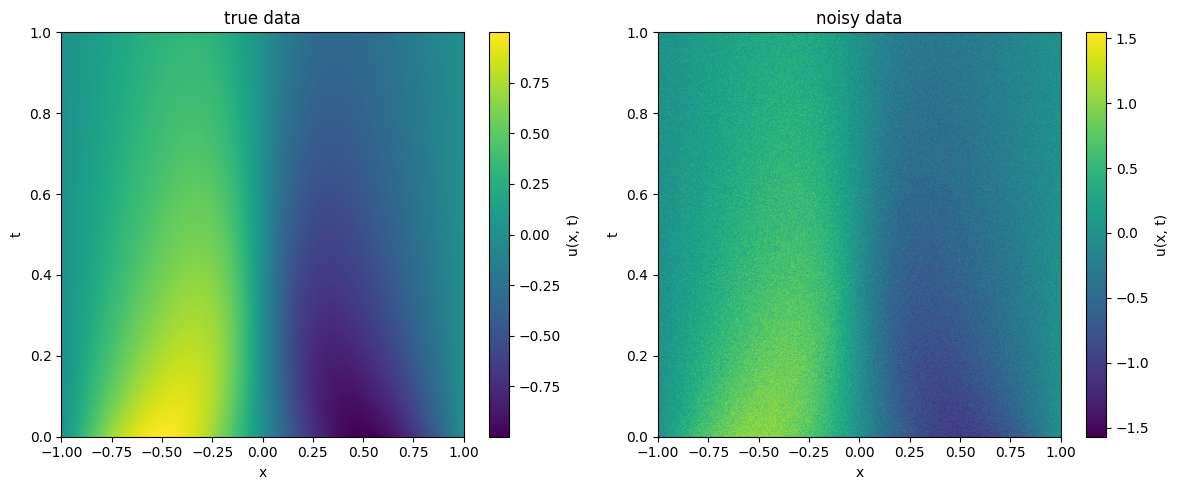

In [ ]:
eps = 0.15

# plot the numerical solution without noise
u_solution = odeint(burgers_equation, u0, np.linspace(0, tmax, nt))
fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(u_solution, extent=[-1, 1, 0, tmax], origin='lower', aspect='auto')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title("true data")

# with noise
noise = eps*np.random.normal(0, 1, [400, 1000])
plt.subplot(1, 2, 2)
plt.imshow(u_solution + noise, extent=[-1, 1, 0, tmax], origin='lower', aspect='auto')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title("noisy data")
plt.tight_layout()
plt.show()

In [ ]:
def noisy_viscous(eps):
    noise = np.random.normal(0, 1, [100, 1])
    # we store the training points in a (nt*nx, 2) array X
    t = np.linspace(0, tmax, nt)
    x_pts, t_pts = np.meshgrid(x, t)
    X = np.stack([x_pts.flatten(), t_pts.flatten()], 1)
    # we flatten the solution array to that the image of X[i] is U[i]
    U = u_solution.reshape(400000, 1)
    # we randomly sample indices in [0, nt*nx - 1] so that the image of X[index] is U[index]
    index = np.random.randint(0, 399999, 100)
    return X[index], U[index] + eps*noise

The model

In [ ]:
def train_with_noise(eps):
    nu = tf.Variable(1.)

    def burgers_pde(z, u):
        du_x = dde.grad.jacobian(u, z, i=0, j=0)
        du_t = dde.grad.jacobian(u, z, i=0, j=1)
        du_xx = dde.grad.hessian(u, z, i=0, j=0)
        return du_t + u * du_x - nu * du_xx

    geom = dde.geometry.Interval(-L, L)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    bc = dde.icbc.DirichletBC(geomtime, lambda z: 0, lambda _, on_boundary: on_boundary)
    ic = dde.icbc.IC(
        geomtime, lambda z: u0_func(z[:, 0:1]), lambda _, on_initial: on_initial
    )

    observe_z, ob_u = noisy_viscous(eps)
    observe_u = dde.icbc.PointSetBC(observe_z, ob_u)

    data = dde.data.TimePDE(
        geomtime,
        burgers_pde,
        [ic, bc, observe_u],
        num_domain=100,
        num_boundary=20,
        num_initial=16,
        anchors=observe_z,
    )
    net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    parameters = dde.callbacks.VariableValue([nu], period=1000)
    model.compile("adam", lr=1e-3)
    losshistory, train_state = model.train(iterations=20000, callbacks=[parameters])
    return parameters.value

In [ ]:
epsilon = np.linspace(0,0.1,11)
param = []
for eps in epsilon:
    param.append(train_with_noise(eps))

Compiling model...
Building feed-forward neural network...
'build' took 0.115853 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.305325 s

Training model...

0         [4.66e-03, 5.67e-01, 4.86e-03, 2.19e-01]    [4.66e-03, 5.67e-01, 4.86e-03, 2.19e-01]    []  
0 [1.00e+00]
1000      [2.73e-03, 1.88e-03, 5.33e-04, 1.37e-03]    [2.73e-03, 1.88e-03, 5.33e-04, 1.37e-03]    []  
1000 [1.25e-01]
2000      [5.71e-04, 2.33e-04, 4.19e-05, 2.56e-05]    [5.71e-04, 2.33e-04, 4.19e-05, 2.56e-05]    []  
2000 [1.02e-01]
3000      [2.81e-04, 1.50e-04, 3.10e-05, 1.80e-05]    [2.81e-04, 1.50e-04, 3.10e-05, 1.80e-05]    []  
3000 [1.02e-01]
4000      [2.39e-04, 1.00e-04, 3.61e-05, 2.07e-05]    [2.39e-04, 1.00e-04, 3.61e-05, 2.07e-05]    []  
4000 [1.02e-01]
5000      [1.62e-04, 6.59e-05, 1.81e-05, 7.99e-06]    [1.62e-04, 6.59e-05, 1.81e-05, 7.99e-06]    []  
5000 [1.01e-01]
6000      [1.32e-04, 4.85e-05, 1.50e-05, 5.95e-06]    [1.32e-04, 4.85e-05, 1.50e-05, 5.95e-06]    []  
6000 [1.01e-01]
7000      [1.09e-04, 3.76e-05, 1.33e-05, 4.70e-06]    [1.09e-04, 3.76e-05, 1.33e-05, 4.70e-06]    []  
7000 [1.01e-01]
8000 

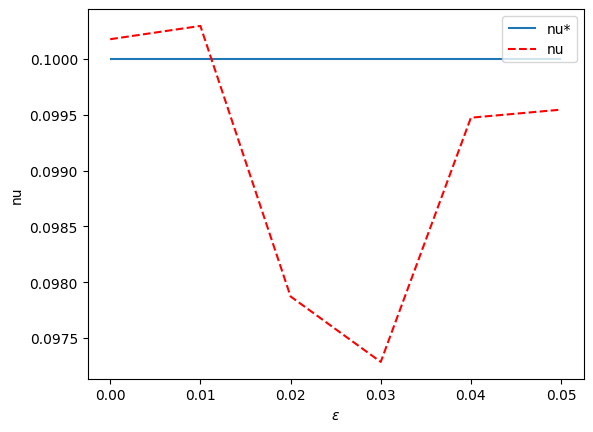

In [ ]:
plt.hlines(0.1, xmin=0, xmax=0.05, label="nu*")
plt.plot(epsilon, param, "r--",label="nu")
plt.xlabel("$\epsilon$")
plt.ylabel("nu")
plt.legend()
plt.show()

## The KDV equation

Consider the KDV equation $$
u_{t}+u_{xxx}-6uu_x =0
$$
Consider a solution of the form $u(x,t)=f(x-ct-a)$ for some $f$. If furthermore we assume that $f(X)\to 0$ as $X\to -\infty$, then there is a unique such solution and is given by
$$
u(x, t) =-\frac{1}{2}c\,\mathrm{sech}^{2}\left[ \frac{\sqrt{c}}{2}\left(
x-ct-a\right) \right].
$$


We want to identify the parameters $a$ and $c$ given some known data points.

In [ ]:
a_star = 3.
c_star = 4.
d_star = np.sqrt(c_star)
L = 5 # half the length of the interval

We use the exact solution to generate the data points:

In [ ]:
def KDV_sol(z):
    return (-c_star / 2) / (np.cosh(d_star * (z[:,0:1] - c_star * z[:,1:2] - a_star) / 2))**2

Let's add some noise to the training points and visualize the result.

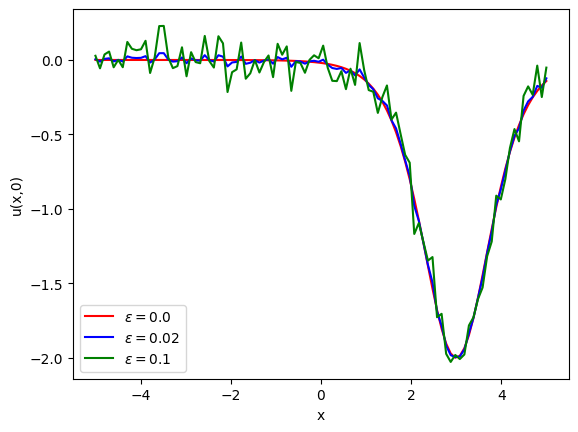

In [ ]:
eps = 0.01
x = np.linspace(-L, L, 100)
t = [0]*100
z = np.stack([x, t], 1)
noise = np.random.normal(0, 1, [100, 1])
plt.plot(z[:,0], KDV_sol(z), label="$\epsilon=0.0$", color="r")
plt.plot(z[:,0], KDV_sol(z)+ 0.02*noise, label="$\epsilon=0.02$", color="b")
plt.plot(z[:,0], KDV_sol(z)+ 0.1*noise, label="$\epsilon=0.1$", color="g")
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.legend()
plt.show()

In [ ]:
x = np.random.uniform(-L, L, [100, 1])
t = np.random.uniform(0, 1, [100, 1])
z = np.hstack((x, t))

noise = np.random.normal(0, 1, [100, 1])

def sech(x):
    return 1/tf.cosh(x)

def noisy_KDV_data(eps):
    y = -c_star*sech(d_star * (z[:,0:1] - c_star * z[:,1:2] - a_star) / 2)**2 / 2
    return z, y + noise*eps

geom = dde.geometry.Interval(-L, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary(_, on_initial):
    return on_initial

net = dde.nn.FNN([2] + [32] * 4 + [1], "tanh", "Glorot normal")

The model

In [ ]:
def train_with_noise(eps):
    a = tf.Variable(1.0)
    c = tf.Variable(1.0)
    d = tf.Variable(1.0)

    def KDV_pde(z, u):
        # z=(x, t)
        u_xx = dde.grad.hessian(u, z, i=0, j=0)
        u_xxx = dde.grad.jacobian(u_xx, z, i=0, j=0)
        u_t = dde.grad.jacobian(u, z, i=0, j=1)
        u_x = dde.grad.jacobian(u, z, i=0, j=0)
        return u_t + u_xxx - 6 * u * u_x

    def KDV0_func(x):
        return -c*sech(d*(x - a) / 2)**2 / 2

    ic = dde.icbc.IC(
        geomtime, lambda z: KDV0_func(z[:, 0:1]), boundary,
    )

    observe_z, ob_u = noisy_KDV_data(eps)
    observe_u = dde.icbc.PointSetBC(observe_z, ob_u)

    data = dde.data.TimePDE(
        geomtime, KDV_pde, ic_bcs=[ic, observe_u],
        num_domain=40, num_boundary=10, num_initial=16,
        anchors=observe_z,
    )
    model = dde.Model(data, net)

    parameters = dde.callbacks.VariableValue([a, c, d], period=1000)
    model.compile("adam", lr=1e-3)
    losshistory, train_state = model.train(iterations=20000, callbacks=[parameters])
    return parameters.value

In [ ]:
epsilon = [0, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1]
param = []
for eps in epsilon:
    param.append(train_with_noise(eps))

Compiling model...
Building feed-forward neural network...
'build' took 0.069108 s

'compile' took 5.265410 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.55e-01, 6.11e-01, 7.51e-01]    [4.55e-01, 6.11e-01, 7.51e-01]    []  
0 [1.00e+00, 1.00e+00, 1.00e+00]
1000      [2.28e-03, 1.06e-02, 6.24e-02]    [2.28e-03, 1.06e-02, 6.24e-02]    []  
1000 [1.73e+00, 5.75e-01, 5.38e-01]
2000      [3.51e-03, 8.52e-03, 4.18e-02]    [3.51e-03, 8.52e-03, 4.18e-02]    []  
2000 [2.67e+00, 9.65e-01, 8.11e-01]
3000      [7.82e-04, 1.08e-03, 8.97e-03]    [7.82e-04, 1.08e-03, 8.97e-03]    []  
3000 [3.27e+00, 2.09e+00, 1.36e+00]
4000      [4.62e-04, 3.11e-04, 3.55e-03]    [4.62e-04, 3.11e-04, 3.55e-03]    []  
4000 [3.09e+00, 2.73e+00, 1.57e+00]
5000      [1.92e-04, 1.20e-04, 1.01e-03]    [1.92e-04, 1.20e-04, 1.01e-03]    []  
5000 [3.00e+00, 3.21e+00, 1.70e+00]
6000      [4.01e-05, 3.28e-05, 2.90e-04]    [4.01e-05, 3.28e-05, 2.90

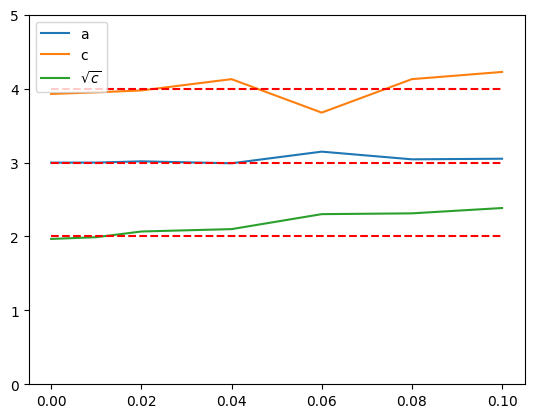

In [ ]:
plt.plot(epsilon, np.array(param)[:,0], label="a")
plt.plot(epsilon, np.array(param)[:,1], label="c")
plt.plot(epsilon, np.array(param)[:,2], label="$\sqrt{c}$")
plt.ylim(0,5)
plt.hlines(y=[2, 3, 4], xmin=0, xmax=0.1, linestyles="--", color="r")
plt.legend()
plt.show()